In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
import tensorflow
tensorflow.random.set_seed(23)
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.constraints import Constraint
from keras import backend
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, Concatenate,BatchNormalization,Add,ZeroPadding2D, ReLU
from tensorflow.keras import initializers, optimizers
from tensorflow.keras.models import Model
from numpy import ones, zeros
from tensorflow.keras.utils import plot_model

2022-07-06 18:06:14.091737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 18:06:14.178765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 18:06:14.179501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 18:06:14.180698: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 96)   4704        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 74, 74, 96)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 36, 36, 184)  282808      leaky_re_lu[0][0]                
______________________________________________________________________________________________

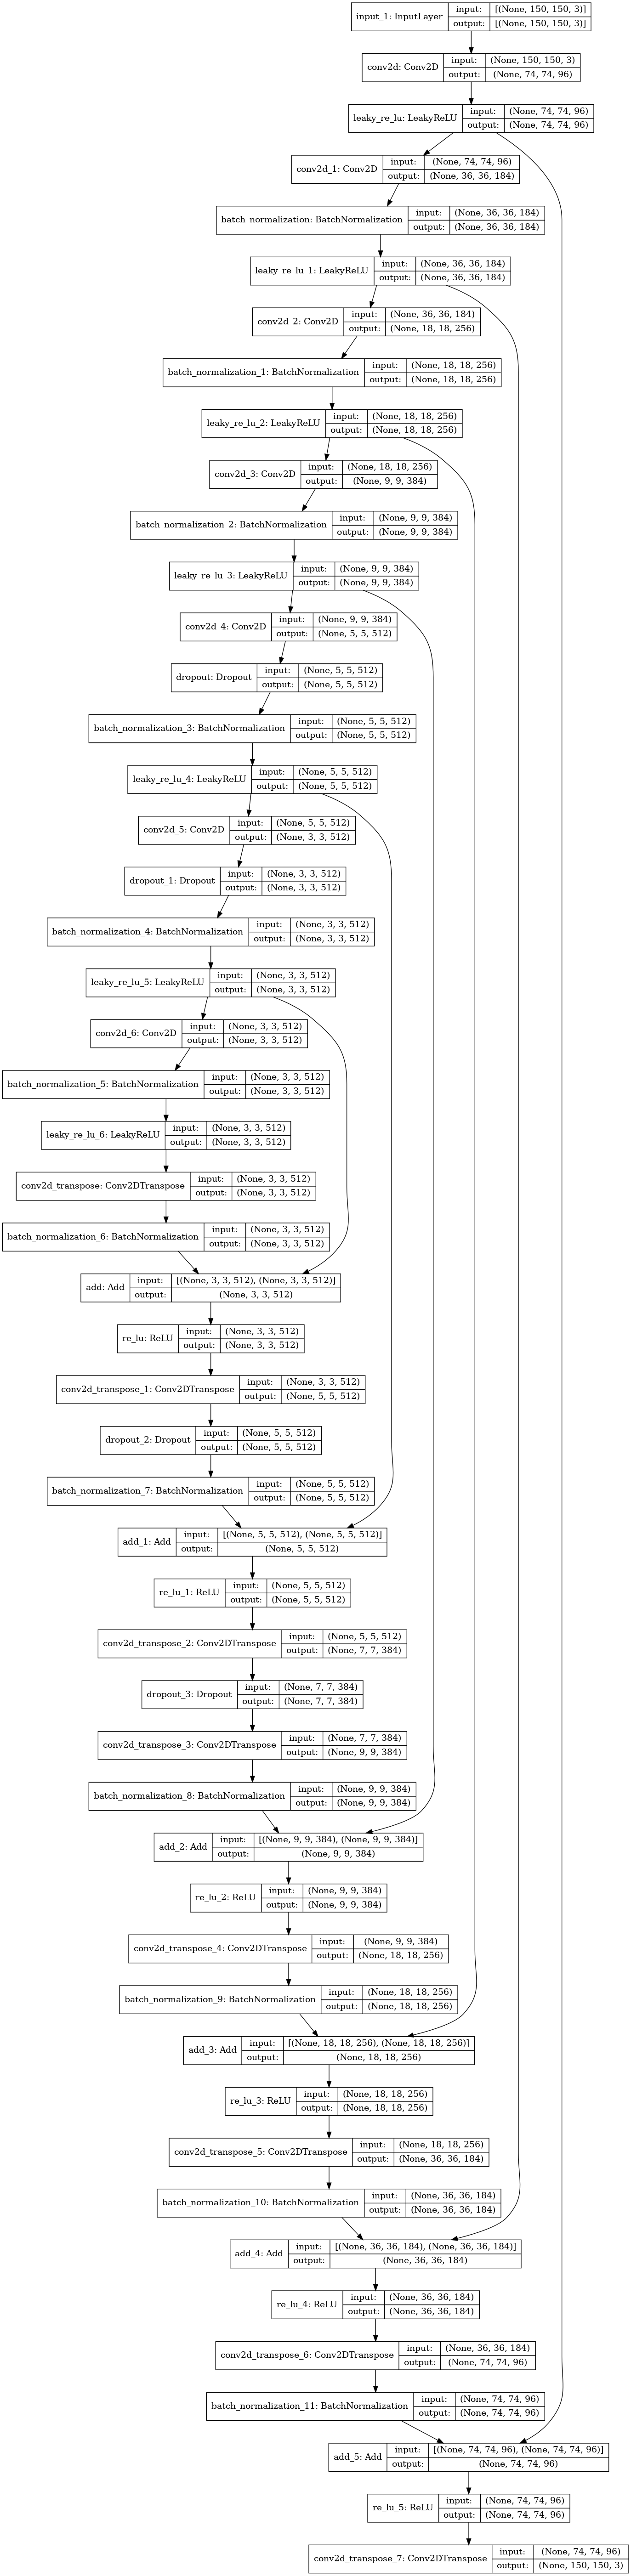

In [6]:
init_k = initializers.HeNormal(seed=23)
init_b = initializers.HeNormal(seed=37)
init = initializers.RandomNormal(stddev=0.02)

def generator():
    input_layer = Input((150,150,3))
    
    # Encoder Block
    d1 = Conv2D(96, (4,4), (2,2), kernel_initializer=init,
                bias_initializer=init)(input_layer)
    d1 = LeakyReLU()(d1)
    
    d2 = Conv2D(184, (4,4), (2,2), kernel_initializer=init,
                bias_initializer=init)(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU()(d2)
    
    d3 = Conv2D(256, (3,3), (2,2), padding='same', kernel_initializer=init,
                bias_initializer=init)(d2)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU()(d3)
    
    d4 = Conv2D(384, (3,3), (2,2), padding='same', kernel_initializer=init,
                bias_initializer=init)(d3)
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU()(d4)
    
    d5 = Conv2D(512, (2,2), (2,2), padding='same' , kernel_initializer=init,
                bias_initializer=init)(d4)
    d5 = Dropout(0.1)(d5)
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU()(d5)
    
    d6 = Conv2D(512, (2,2), (2,2), padding='same', kernel_initializer=init,
                bias_initializer=init)(d5)
    d6 = Dropout(0.2)(d6)
    d6 = BatchNormalization()(d6)
    d6 = LeakyReLU()(d6)
    d7 = Conv2D(512, (2,2), (1,1), padding='same' , kernel_initializer=init,
                bias_initializer=init)(d6)
    d7 = BatchNormalization()(d7)
    d7 = LeakyReLU()(d7)
    
    #Decoder Block
    u1 = Conv2DTranspose(512, (1,1), (1,1), padding='same',
                         kernel_initializer=init_k, bias_initializer=init_k)(d7)
    u1 = BatchNormalization()(u1)
    u1 = Add()([u1, d6])
    u1 = ReLU()(u1)
    
    u2 = Conv2DTranspose(512, (3,3), (1,1), padding='valid',
                         kernel_initializer=init_k, bias_initializer=init_k)(u1)
    u2 = Dropout(0.1)(u2)
    u2 = BatchNormalization()(u2)
    u2 = Add()([u2,d5])
    u2 = ReLU()(u2)
    
    u3 = Conv2DTranspose(384, (3,3), (1,1), padding='valid', activation='relu',
                         kernel_initializer=init_k, bias_initializer=init_k)(u2)
    u3 = Dropout(0.2)(u3)
    u3 = Conv2DTranspose(384, (3,3), (1,1), padding='valid',
                         kernel_initializer=init_k, bias_initializer=init_k)(u3)
    u3 = BatchNormalization()(u3)
    u3 = Add()([u3, d4])
    u3 = ReLU()(u3)
    
    u4 = Conv2DTranspose(256, (3,3), (2,2), padding='same',
                         kernel_initializer=init_k, bias_initializer=init_k)(u3)
    u4 = BatchNormalization()(u4)
    u4 = Add()([u4, d3])
    u4 = ReLU()(u4)
    
    u5 = Conv2DTranspose(184, (3,3), (2,2), padding='same',
                         kernel_initializer=init_k, bias_initializer=init_k)(u4)
    u5 = BatchNormalization()(u5)
    u5 = Add()([u5, d2])
    u5 = ReLU()(u5)
    
    u6 = Conv2DTranspose(96, (3,3), (2,2), padding='valid', output_padding=(1,1))(u5)
    u6 = BatchNormalization()(u6)
    u6 = Add()([u6, d1])
    u6 = ReLU()(u6)
    u7 = Conv2DTranspose(3, (3,3), (2,2),padding='valid',activation='tanh',
                         output_padding=(1,1))(u6)

    model = Model(inputs = input_layer, outputs=u7)
    return model

generator=generator()
print(generator.summary())
plot_model(generator, to_file='generator.png', show_shapes=True)